In [1]:
import numpy as np
import pandas as pd
import math
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import src.rng_sequences, src.human_sequences,src.constants,src.uORF_Statistics
from collections import Counter
from scipy.optimize import curve_fit
import scipy.special
from scipy.stats import poisson

import polygraph.input, polygraph.sequence, polygraph.visualize

 # Generating data files

In [ ]:
'''Defining params'''
seqnum=100
seqlen=160
myu=5.345801185151601
sigma=0.8416777786431029
factor_a=66009.38523606668
params=[myu,sigma,factor_a]
np.random.seed(12345)

In [ ]:
seqs1 = src.rng_sequences.randomseqs(seqnum,seqlen,group_name="Random_gc70",seed=12345,gc_content=0.7)
seqs2 = src.rng_sequences.randomseqs(seqnum,seqlen,group_name="Random_gc50",seed=12345)

In [ ]:
np.savetxt('data/small_dataset.txt' , seqs1, delimiter='\t',newline='\n',fmt='%s')

In [2]:
testseqs=polygraph.seqs=polygraph.input.read_seqs('data/small_dataset.txt')
testseqs

,Sequence,Group
SeqID,,
seq_0,CCGGCCGCGUCUGACUGCGCACCCCGCAAGUGUGUUGUCCCGCUCC...,Random_gc70
seq_1,UGGGGCUUGUUGGGACAUAGCACUCCUGCCGAGUCCACGCGACCUA...,Random_gc70
seq_2,CACCCCGCUCGCGCCCAGCAGCGGACAUGCUCCACGAGCGCUGACA...,Random_gc70
seq_3,CUGAGCCGUCGAACGCGCCGGUAAGCUGGAGUUCCUCCCGAAGGCG...,Random_gc70
seq_4,GCUCGACUAGCGUUCUCCGGGCCGAAAGGCGUACCCCGGACGGGUC...,Random_gc70
...,...,...
seq_95,AGGGGAGAUCCUCAGGGGAUGGGGCGCAACCGUUCGACCAGCCUCG...,Random_gc70
seq_96,CAGCCCGGCCGCCCGACUGUGCCUCGUGCGUCAAGAGGGCCGUGCG...,Random_gc70
seq_97,UAUGAAAAAGAUGUUAGGGGGACGAGCCGGAGCGCGCCGUGCCGUG...,Random_gc70


In [ ]:
seqs3=src.rng_sequences.randomlengthseqs(params,8000,90000,"Random_dl_gc50",seed=12345)
seqs4=src.rng_sequences.randomlengthseqs(params,8000,90000,"Random_dl_gc70",seed=12345,gc_content=0.7)

In [ ]:
'''This code is used to generate a dataset with continous IDs and save it in a txt file'''
randomseqs=np.concatenate([seqs1,seqs2,seqs3],axis=0)
randomseqsindex=np.array([f"seq_{i+1}" for i in range(len(randomseqs))])
randomseqs=np.vstack((randomseqsindex,randomseqs.T)).T
np.savetxt("data/random_dataset.txt",randomseqs,delimiter="\t",newline="\n",fmt='%s')

In [ ]:
'''Here we read out the human genome sequences and save it in a txt file'''
humanseqs=src.human_sequences.readFASTA("data/gencode_5utrs_human.fa")
humanseqs=src.human_sequences.delDupes(humanseqs)
np.savetxt("data/humanseqsRNA.txt",humanseqs,delimiter="\t",newline="\n",fmt='%s')

In [ ]:
''' Here we write every Sequence into one txt file'''
seqfiles=['data/humanseqsRNA.txt','data/random_dataset.txt']
with open('data/full_dataset.txt','w') as outfile:
    for fname in seqfiles:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [4]:
seqs=polygraph.input.read_seqs('data/full_dataset.txt',incl_ids=True)
seqs

,Sequence,Group
SeqID,,
ENST00000641515.2,CCCAGAUCUCUUCAGUUUUUAUGCCUCAUUCUGUGAAAAUUGCUGU...,Human
ENST00000616016.5,GGCGGCGGAGUCUCCCAAGUCCCCGCCGGGCGGGCGCGCGCCAGUG...,Human
ENST00000437963.5,CAGCGCUUGGGGCUCGCGGGCCGCUCCCUCCGCUCGGAAGGGAAAA...,Human
ENST00000342066.8,GCAGAGCCCAGCAGAUCCCUGCGGCGUUCGCGAGGGUGGGACGGGA...,Human
ENST00000338591.8,GGGAGUGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCUCC...,Human
...,...,...
seq_269996,UACCUUUUACUCUAGGACACGGUGAUUUCACUGAGAGCCUCACAGC...,Random_dl_gc50
seq_269997,UAUAGUGCCUUCUGUAAGCUGUCGCAGGAACUAGCAGAGGUCGCUA...,Random_dl_gc50
seq_269998,GCAAGGUAGACGCUACGUCUUCCGAUCAUAGGCUUUCCGGAGGCUG...,Random_dl_gc50


# Generating statistics for the Sequences 

In [5]:
'''Sequence lengths'''
seqs['Sequence Length']=seqs.Sequence.apply(len)

In [6]:
'''GC Content'''
seqs['GC Content']=polygraph.sequence.gc(seqs)

In [7]:
'''uORF counts'''
counts= src.uORF_Statistics.uORFs(seqs)
seqs=pd.concat([seqs,counts],axis=1)

In [8]:
seqs

,Sequence,Group,Sequence Length,GC Content,all uORFs,all ouORFs,all mean lengths,uORFs,CUG_uORFs,GUG_uORFs,...,frame2_mean_GUG_uORF_length,frame3_uORFs,frame3_ouORFs,frame3_mean_uORF_length,frame3_CUG_uORFs,frame3_CUG_ouORFs,frame3_mean_CUG_uORF_length,frame3_GUG_uORFs,frame3_GUG_ouORFs,frame3_mean_GUG_uORF_length
SeqID,,,,,,,,,,,,,,,,,,,,,
ENST00000641515.2,CCCAGAUCUCUUCAGUUUUUAUGCCUCAUUCUGUGAAAAUUGCUGU...,Human,60,0.400000,2.0,1.0,3.000000,0.0,2.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
ENST00000616016.5,GGCGGCGGAGUCUCCCAAGUCCCCGCCGGGCGGGCGCGCGCCAGUG...,Human,509,0.809430,14.0,2.0,110.511111,1.0,8.0,5.0,...,315.00,0.0,0.0,0.0,3.0,0.0,109.0,3.0,0.0,85.000000
ENST00000437963.5,CAGCGCUUGGGGCUCGCGGGCCGCUCCCUCCGCUCGGAAGGGAAAA...,Human,60,0.666667,0.0,1.0,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
ENST00000342066.8,GCAGAGCCCAGCAGAUCCCUGCGGCGUUCGCGAGGGUGGGACGGGA...,Human,90,0.666667,1.0,2.0,27.000000,0.0,1.0,0.0,...,0.00,0.0,0.0,0.0,1.0,0.0,27.0,0.0,0.0,0.000000
ENST00000338591.8,GGGAGUGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCUCC...,Human,110,0.745455,1.0,0.0,60.000000,0.0,0.0,1.0,...,60.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_269996,UACCUUUUACUCUAGGACACGGUGAUUUCACUGAGAGCCUCACAGC...,Random_dl_gc50,551,0.504537,23.0,3.0,59.583333,8.0,10.0,5.0,...,0.00,3.0,0.0,49.0,6.0,1.0,50.5,4.0,0.0,70.500000
seq_269997,UAUAGUGCCUUCUGUAAGCUGUCGCAGGAACUAGCAGAGGUCGCUA...,Random_dl_gc50,82,0.402439,2.0,1.0,15.000000,0.0,1.0,1.0,...,0.00,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.000000
seq_269998,GCAAGGUAGACGCUACGUCUUCCGAUCAUAGGCUUUCCGGAGGCUG...,Random_dl_gc50,126,0.500000,2.0,0.0,18.000000,0.0,1.0,1.0,...,12.00,0.0,0.0,0.0,1.0,0.0,24.0,0.0,0.0,0.000000


# Plots

In [9]:
 '''Wir kreieren Nebendataframes um das Darstellen der Daten zu erleichtern'''
gc50seqs=seqs.loc[seqs['Group']=='Random_gc50']
gc70seqs=seqs.loc[seqs['Group']=='Random_gc70']
humanseqs=seqs.loc[seqs['Group']=='Human']
gc50dlseqs=seqs.loc[seqs['Group']=='Random_dl_gc50']
lengthdistributed=pd.concat([humanseqs,gc50dlseqs])

In [ ]:
humanseqs160=humanseqs.loc[humanseqs["Sequence Length"] <= 160]
humanseqs160=humanseqs160[humanseqs160["Sequence Length"]>=100]
humanseqs100=humanseqs.loc[humanseqs["Sequence Length"]<=100]
print(len(humanseqs160)/len(humanseqs))

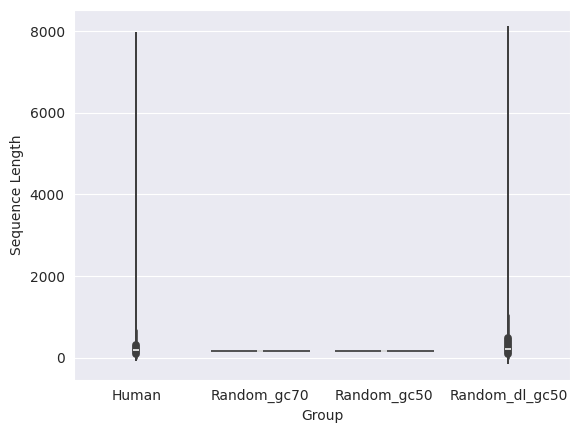

In [10]:
#Sequenzlaenge
sns.violinplot(data=seqs,x='Group',y='Sequence Length');

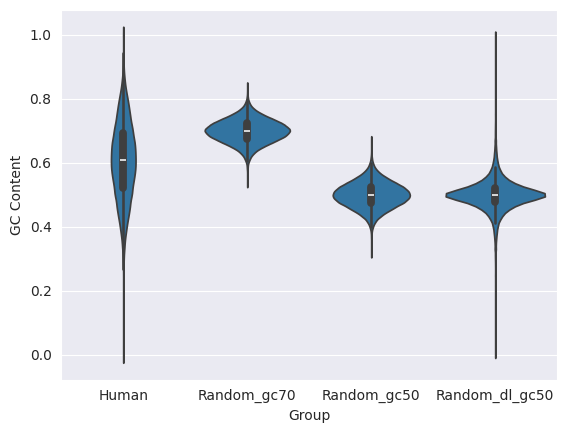

In [11]:
#GC Content 
sns.violinplot(data=seqs,x='Group',y='GC Content');

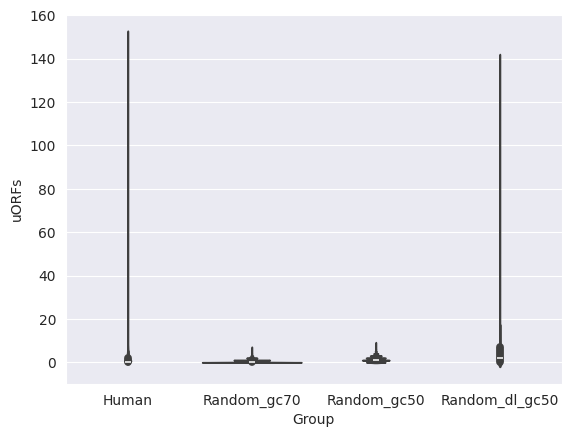

In [12]:
# uORF Anzahl(Summe aus allen reading frames)
sns.violinplot(data=seqs,x='Group',y='uORFs');

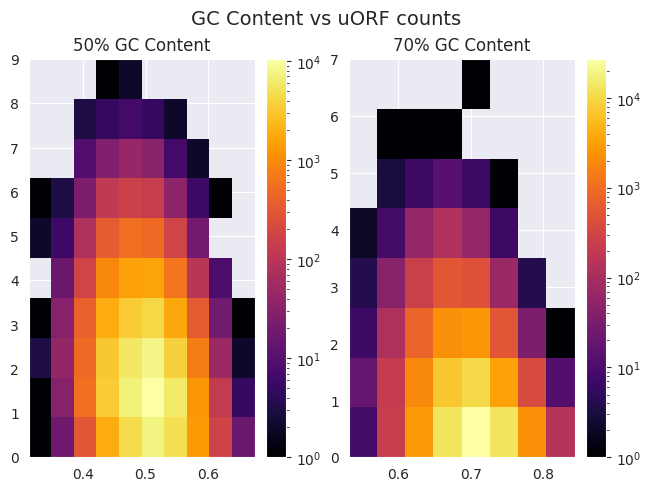

In [13]:
#GC Content vs. uORF anzahl
fig,axs = plt.subplots(nrows=1, ncols=2,layout='constrained' )
im1=axs[0].hist2d(gc50seqs['GC Content'],gc50seqs['uORFs'],norm=colors.LogNorm(),cmap='inferno',bins=10)
im2= axs[1].hist2d(gc70seqs['GC Content'],gc70seqs['uORFs'],norm=colors.LogNorm(),cmap='inferno',bins=8)
axs[0].set_title("50% GC Content")
axs[1].set_title("70% GC Content")
fig.colorbar(im1[3],ax=axs[0])
fig.colorbar(im2[3],ax=axs[1])
fig.suptitle('GC Content vs uORF counts',fontsize=14)
plt.show()

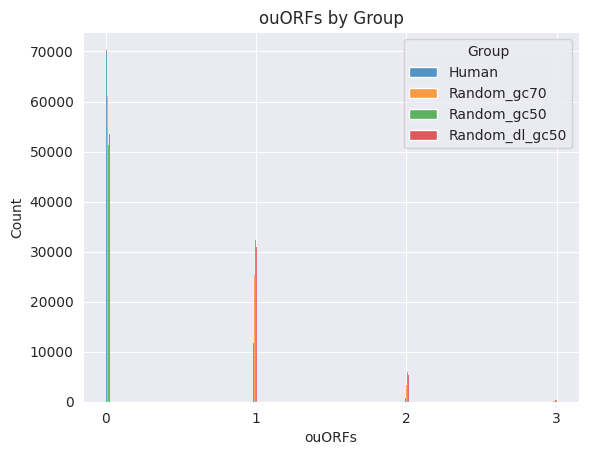

In [14]:
#Menge an overlapping uORFs pro Gruppe
im1=sns.histplot(x=seqs["ouORFs"],hue=seqs["Group"],multiple="dodge")
#im1.set_yscale('log')
im1.set_xticks([0,1,2,3])
im1.set_xlabel("ouORFs")
plt.title('ouORFs by Group')
plt.show()

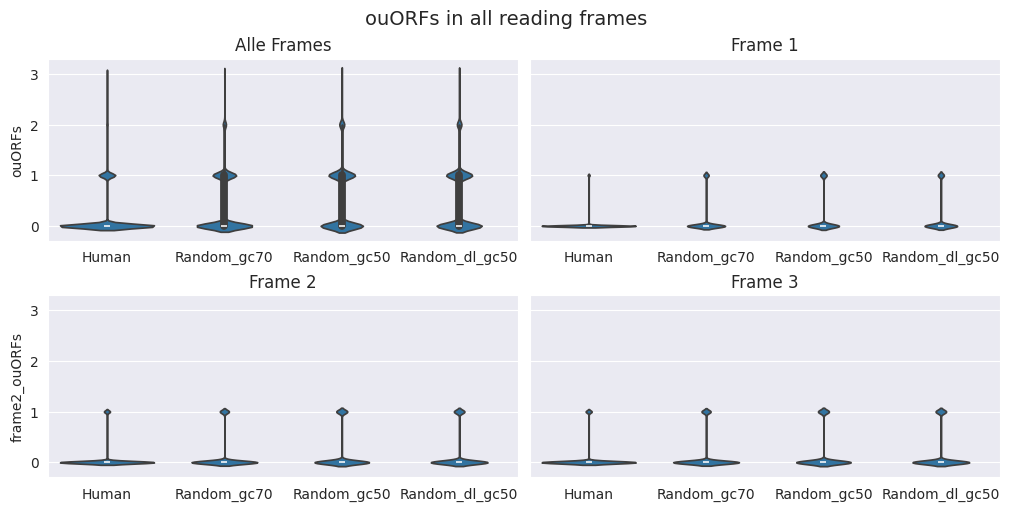

In [15]:
#overlapping uORFs in allen reading Frames
fig2, axs2=plt.subplots(2,2,layout='constrained', sharey=True,figsize=(10,5) )
sns.violinplot(x=seqs["Group"],y=seqs["ouORFs"],ax=axs2[0,0])
sns.violinplot(x=seqs["Group"],y=seqs["frame1_ouORFs"],ax=axs2[0,1])
sns.violinplot(x=seqs["Group"],y=seqs["frame2_ouORFs"],ax=axs2[1,0])
sns.violinplot(x=seqs["Group"],y=seqs["frame2_ouORFs"],ax=axs2[1,1])
for arr in axs2:
    for ax in arr:
        ax.minorticks_on()
        ax.set_xlabel("")
axs2[0,0].set_title("Alle Frames")
axs2[0,1].set_title("Frame 1")
axs2[1,0].set_title("Frame 2")
axs2[1,1].set_title("Frame 3")
fig2.suptitle('ouORFs in all reading frames',fontsize=14)
plt.show()

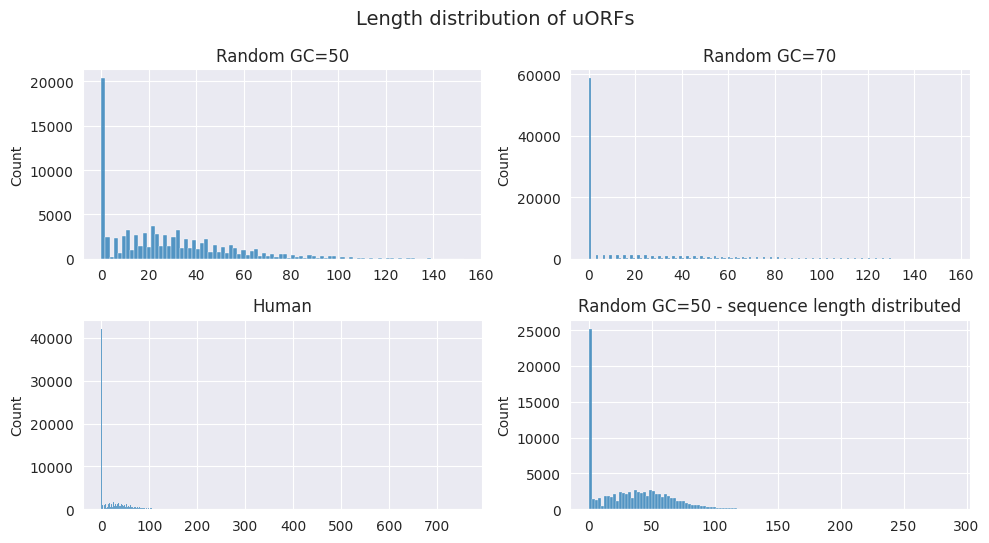

In [16]:
fig3, axs3 =plt.subplots(2,2,layout='tight',figsize=(10,5.5))
sns.histplot(x=gc50seqs['mean_uORF_length'],ax=axs3[0,0])
sns.histplot(x=gc70seqs['mean_uORF_length'],ax=axs3[0,1])
sns.histplot(x=humanseqs['mean_uORF_length'],ax=axs3[1,0])
sns.histplot(x=gc50dlseqs['mean_uORF_length'],ax=axs3[1,1])
for arr in axs3:
    for ax in arr:
        ax.minorticks_on()
        ax.set_xlabel("")
        #ax.set_yscale('log')
axs3[0,0].set_title("Random GC=50")
axs3[0,1].set_title("Random GC=70")
axs3[1,0].set_title("Human")
axs3[1,1].set_title("Random GC=50 - sequence length distributed")
fig3.suptitle("Length distribution of uORFs",fontsize=14)
plt.show()

- higher GC Content: More ouORFs, less full uORFs

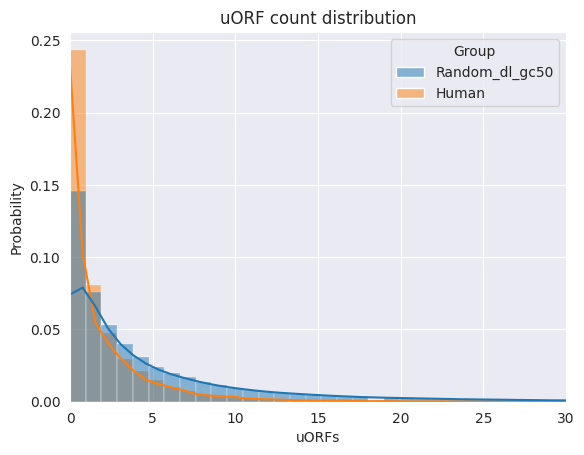

In [17]:
hue_order=['Random_dl_gc50','Human']
sns.histplot(data=lengthdistributed, x='uORFs', hue='Group',stat='probability',hue_order=hue_order,kde=True,bins=160);
plt.xlim(0,30);
#plt.xticks(np.arange(1,31));

plt.title("uORF count distribution")
plt.show()



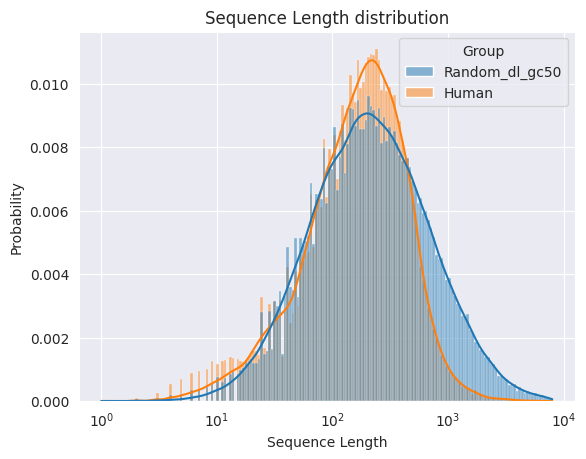

In [18]:
hue_order=['Random_dl_gc50','Human']
sns.histplot(data=lengthdistributed, x='Sequence Length', hue='Group',stat='probability',hue_order=hue_order,kde=True,log_scale=True)
plt.title("Sequence Length distribution")
plt.show()

# Metadata

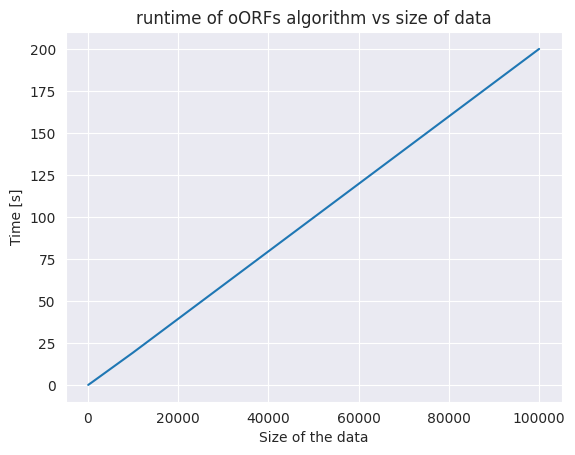

In [19]:
'''Plot of runtimes of the uORF_statistics method over the size of the data (number or length of sequences)'''
times=[0.212,1.920,19.402,200.295]
sizes=[100,1000,10000,100000]
plt.plot(sizes,times)
plt.xlabel("Size of the data")
plt.ylabel("Time [s]")
plt.title("runtime of oORFs algorithm vs size of data")
plt.show()

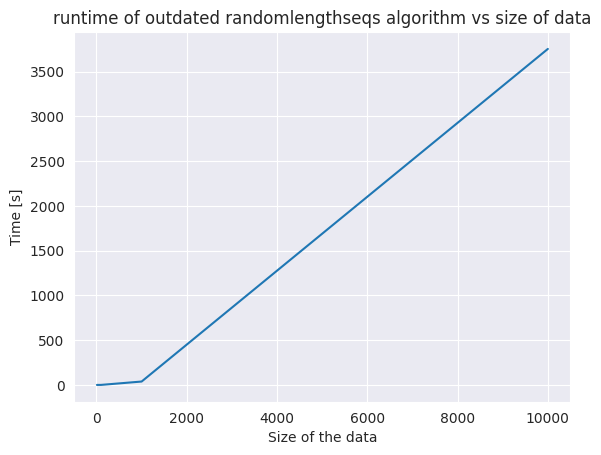

In [20]:
times=[0.021,0.256,37.857,3753]
sizes=[10,100,1000,10000]
plt.plot(sizes,times)
plt.xlabel("Size of the data")
plt.ylabel("Time [s]")
plt.title("runtime of outdated randomlengthseqs algorithm vs size of data")
plt.show()

# testing

In [ ]:
def testfunc(a,b):
    print(a+b)
def testingtestfunc(func,a,b):
    func(a,b)
    
testingtestfunc(testfunc,1,2)

In [ ]:
print(sum)

In [ ]:
rng = np.random.default_rng(seed=3)
a=rng.choice([0,1,3],3)
b=np.array([0,1,2,3])
for i in b[1:]:
    print(i)

In [ ]:
def lognormalfunc(x,myu,sigma,a):
    return a*np.exp(-1*(np.log(x)-myu)**2/(2*sigma)**2)/(x*sigma*np.sqrt(2*np.pi))

In [ ]:
sns.scatterplot(x=x_plot,y=lognormalfunc(x_plot,myu,sigma,factor_a),size=1,marker=".");

In [ ]:
x_plot=np.arange(1,8000)
distribution=lognormalfunc(x_plot,myu,sigma,factor_a)
distribution=distribution/sum(distribution)
#print(sum(distribution))
rng=np.random.default_rng()
lengths=rng.choice(x_plot, 100000 , p=distribution)

In [ ]:
im3=sns.histplot(lengths,kde=True)
im3.lines[0].set_color('crimson')


In [ ]:
im4=sns.scatterplot(x=x_plot,y=distribution,size=1,marker=".")
#im4.lines[0].set_color('crimson')

In [ ]:
lengthdata=list(humanseqs['Sequence Length'])
lengthdata=Counter(lengthdata)
x,y=[],[]
for i,j in lengthdata.items():
    x.append(i)
    y.append(j)
y=np.array(y)
sns.scatterplot(x=x,y=y,size=1,marker=".");

In [ ]:
params, cov_matrix= curve_fit(lognormalfunc,x,y)
x_plot=np.arange(1,8000)
plt.plot(x_plot,lognormalfunc(x_plot,params[0],params[1],params[2]))
plt.plot(x,y,linestyle='None',marker=".")

myu=params[0]
sigma=params[1]
factor_a=params[2]
print(myu,sigma,factor_a)


In [ ]:
def poissonfunc(x,lamb,a):
    return a*poisson.pmf(x,lamb)
params1, cov_matrix1 = curve_fit(poissonfunc,x,y)
x_plot1=(np.arange(0,8000))
plt.plot(x_plot1,poissonfunc(x_plot1,params1[0],params1[1]))
plt.plot(x,y,linestyle='None',marker=".")

In [ ]:
x_plot=np.arange(1,8000)
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

    
#plt.plot(x_plot,lognormalfunc(x_plot,myu,sigma))
#plt.plot(x_plot,softmax(lognormalfunc(x_plot,myu,sigma)))
#plt.plot(x_plot,scipy.special.softmax(lognormalfunc(x_plot,myu,sigma)))
print([sum(lognormalfunc(x_plot,myu,sigma)),sum(softmax(lognormalfunc(x_plot,myu,sigma)))])

In [ ]:
#New approach for uORFs function
def uORFs(seqs):
    frames=src.uORF_Statistics.codons(seqs)
    template={
        "uORFs":list(np.zeros(len(frames))),
        "ouORFs":list(np.zeros(len(frames))),
        "mean_uORF_length":list(np.zeros(len(frames))),
        
        "CUG_uORFs":list(np.zeros(len(frames))),
        "CUG_ouORFs":list(np.zeros(len(frames))),
        "mean_CUG_uORF_length":list(np.zeros(len(frames))),
        
        
        "GUG_uORFs":list(np.zeros(len(frames))),
        "GUG_ouORFs":list(np.zeros(len(frames))),
        "mean_GUG_uORF_length":list(np.zeros(len(frames))),
    }
    framedict={}
    for frame in range(3):
        framedict[f"frame{frame+1}"]=pd.DataFrame(template)
        for index in range(len(frames[f"frame{frame+1}"])):
            seq=frames[f"frame{frame+1}"][index]
            lengths=[]
            CUG_lengths=[]
            GUG_lengths=[]
            for codon in range(len(seq)):
                if seq[codon]=='AUG':
                    uORF_length=0
                    ouORF_bool=True
                    for nextcodon in range(len(seq)-codon-1):
                        uORF_length+=3
                        if seq[nextcodon+codon+1] in src.constants.stopcodons:
                            ouORF_bool=False
                            framedict[f"frame{frame+1}"].loc[index,"uORFs"]+=1
                            lengths.append(uORF_length)
                            break
                    if ouORF_bool:
                        framedict[f"frame{frame+1}"].loc[index,"ouORFs"]+=1
                        break
                    
                if seq[codon]=='CUG':
                    uORF_length=0
                    ouORF_bool=True
                    for nextcodon in range(len(seq)-codon-1):
                        uORF_length+=3
                        if seq[nextcodon+codon+1] in src.constants.stopcodons:
                            ouORF_bool=False
                            framedict[f"frame{frame+1}"].loc[index,"CUG_uORFs"]+=1
                            CUG_lengths.append(uORF_length)
                            break
                    if ouORF_bool:
                        framedict[f"frame{frame+1}"].loc[index,"CUG_ouORFs"]+=1
                        break
                        
                if seq[codon]=='GUG':
                    uORF_length=0
                    ouORF_bool=True
                    for nextcodon in range(len(seq)-codon-1):
                        uORF_length+=3
                        if seq[nextcodon+codon+1] in src.constants.stopcodons:
                            ouORF_bool=False
                            framedict[f"frame{frame+1}"].loc[index,"GUG_uORFs"]+=1
                            GUG_lengths.append(uORF_length)
                            break
                    if ouORF_bool:
                        framedict[f"frame{frame+1}"].loc[index,"GUG_ouORFs"]+=1
                        break
             
            if len(lengths)>0:
                framedict[f"frame{frame+1}"].loc[index,"mean_uORF_length"] = sum(lengths)/len(lengths)   
            
            if len(CUG_lengths)>0:
                framedict[f"frame{frame+1}"].loc[index,"mean_CUG_uORF_length"]=sum(CUG_lengths)/len(CUG_lengths)
            if len(GUG_lengths)>0:
                framedict[f"frame{frame+1}"].loc[index,"mean_GUG_uORF_length"]=sum(GUG_lengths)/len(GUG_lengths)
             
    counts=pd.DataFrame()
    
    for key in framedict:
        for column in framedict[key].columns:
            counts[f"{key}_{column}"] = framedict[key].loc[:,column]
            
    counts["uORFs"]=counts["frame1_uORFs"]+counts["frame2_uORFs"]+counts["frame3_uORFs"]
    counts["CUG_uORFs"]=counts["frame1_CUG_uORFs"]+counts["frame2_CUG_uORFs"]+counts["frame3_CUG_uORFs"]
    counts["GUG_uORFs"]=counts["frame1_GUG_uORFs"]+counts["frame2_GUG_uORFs"]+counts["frame3_GUG_uORFs"]
    counts["ouORFs"]=counts["frame1_ouORFs"]+counts["frame2_ouORFs"]+counts["frame3_ouORFs"]
    counts["CUG_ouORFs"]=counts["frame1_CUG_ouORFs"]+counts["frame2_CUG_ouORFs"]+counts["frame3_CUG_ouORFs"]
    counts["GUG_ouORFs"]=counts["frame1_GUG_ouORFs"]+counts["frame2_GUG_ouORFs"]+counts["frame3_CUG_ouORFs"]
    counts["all uORFs"]=counts["uORFs"]+counts["CUG_uORFs"]+counts["GUG_uORFs"]
    counts["all ouORFs"]=counts["ouORFs"]+counts["CUG_ouORFs"]+counts["GUG_ouORFs"]
    
    counts = counts.replace(0, np.nan)
    counts["mean_uORF_length"] = counts.loc[:,["frame1_mean_uORF_length","frame2_mean_uORF_length","frame3_mean_uORF_length"]].mean(axis=1)
    counts["mean_CUG_uORF_length"] = counts.loc[:,["frame1_mean_CUG_uORF_length","frame2_mean_CUG_uORF_length","frame3_mean_CUG_uORF_length"]].mean(axis=1)
    counts["mean_GUG_uORF_length"] = counts.loc[:,["frame1_mean_GUG_uORF_length","frame2_mean_GUG_uORF_length","frame3_mean_GUG_uORF_length"]].mean(axis=1)
    counts["all mean lengths"] = counts.loc[:,["mean_uORF_length","mean_CUG_uORF_length","mean_GUG_uORF_length"]].mean(axis=1)
    counts = counts.replace(np.nan, 0)

    cols_in_front = ["all uORFs","all ouORFs","all mean lengths","uORFs","CUG_uORFs","GUG_uORFs","ouORFs","CUG_ouORFs","GUG_ouORFs","mean_uORF_length","mean_CUG_uORF_length","mean_GUG_uORF_length"]
    counts = counts.loc[:,[c for c in cols_in_front if c in counts.columns] + [c for c in counts if c not in cols_in_front]]
    
    if type(seqs) == pd.core.frame.DataFrame:
        counts.insert(loc=0,column='SeqID',value=seqs.index)
        counts.set_index('SeqID', inplace=True)
    
    return counts

In [3]:
singleseq="CACCCCGCUCGCGCCCAGCAGCGGACAUGCUCCACGAGCGCUGACAGCGUCGCCGUGCAACAAUCCUGGCGCCUGCCGCCGGCGAGCGGUCGACCGACCCGCACCGGUUCUCUAUGCCCCGCUACGGGCGGCCCGAGGCUUUACUACCCGGGCGCUUACC"
singleseq1="CCGAGAUGUCACACACGCAUAAAUGGUGAUGCUGGCGCCUUCCGAAGGCGGAGGGCAUAACCUAGGAAUGCCGCGUGCAAACCCCAGGUGGGAUUGUGUGUGGCCAACAGGGGGCCCUUGGUCGCUGUCUCUGUAAAGGGUGGGUGUGCUCUGCUCCCCG"
singleseqcodons=src.uORF_Statistics.codons(singleseq1)
counts=src.uORF_Statistics.uORFs(testseqs)
counts


,all uORFs,all ouORFs,all mean lengths,uORFs,CUG_uORFs,GUG_uORFs,ouORFs,CUG_ouORFs,GUG_ouORFs,mean_uORF_length,...,frame2_mean_GUG_uORF_length,frame3_uORFs,frame3_ouORFs,frame3_mean_uORF_length,frame3_CUG_uORFs,frame3_CUG_ouORFs,frame3_mean_CUG_uORF_length,frame3_GUG_uORFs,frame3_GUG_ouORFs,frame3_mean_GUG_uORF_length
SeqID,,,,,,,,,,,,,,,,,,,,,
seq_0,2.0,4.0,94.50,0.0,1.0,1.0,0.0,2.0,2.0,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
seq_1,0.0,2.0,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
seq_2,1.0,4.0,15.00,1.0,0.0,0.0,0.0,2.0,2.0,15.00,...,0.0,1.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0
seq_3,2.0,2.0,34.50,0.0,2.0,0.0,1.0,0.0,1.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
seq_4,0.0,2.0,0.00,0.0,0.0,0.0,1.0,0.0,1.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_95,0.0,4.0,0.00,0.0,0.0,0.0,1.0,2.0,1.0,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
seq_96,4.0,1.0,46.00,0.0,3.0,1.0,0.0,0.0,1.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
seq_97,5.0,0.0,27.75,3.0,1.0,1.0,0.0,0.0,0.0,32.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
singleseqcodons.T.to_csv("data/testcodons.csv",sep="\t",index=False)


In [ ]:
mydict={"frame1":[10,11,12],"frame2":[20,21,22],"frame3":[30,31,32]}
num=69
df=pd.DataFrame(mydict)
df2=pd.DataFrame()
df["mean"]=df.loc[:,["frame2","frame3"]].mean(axis=1)
df

In [ ]:
mydict1={"feature1":[0],"feature2":[0],"feature3":[0]}
template=pd.DataFrame(mydict1)
l=[]
for frame in range(3):
    r1=np.random.randint(1,10)
    r2=np.random.randint(1,10)
    r3=np.random.randint(1,10)
    df=pd.DataFrame(mydict1)
    df.loc[0,"feature1"]=r1
    df.loc[0,"feature2"]=r2
    df.loc[0,"feature3"]=r3
    l.append(df)
print(l[0])
print(l[1])
print(l[2])

In [ ]:
var1=10
var2=var1
var1=11
var2

In [ ]:
for i in range(10):
    print(i)
    if i ==5 :
        print("test")
        for j in range(3):
            print("test", 2)
            if j==1:
                print("break")
                break